## Average kmer frequency and Saliency Map per Clade

In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from supervised_dna.utils import fcgrpos2kmers, array2img
from supervised_dna.saliency_maps import get_kmer_importance

2022-02-10 13:23:52.283883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 13:23:52.283930: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
k = 8
CLADES = ['S','L','G','V','GR','GH','GV','GK']
clade = "G"#CLADES[-3]

In [6]:
# results on prediction
path_model_preds = "results_nextclade_comparison.csv"
model_preds = pd.read_csv(path_model_preds)

In [9]:
# get ground truth for the sequence
model_preds["ground_truth"] = model_preds["path_fasta"].apply(lambda path: path.split("/")[2])
model_preds["TP"] = model_preds.apply(lambda row: row["ground_truth"]==row["pred_class"], axis=1)

In [13]:
model_preds.groupby(["ground_truth","TP"]).size()

ground_truth  TP   
G             False     188
              True     4673
GH            False      49
              True     4788
GK            False     203
              True     4721
GR            False     380
              True     4501
GV            False     103
              True     4862
L             False      76
              True     4731
S             False      57
              True     4631
V             False      39
              True     4747
dtype: int64

In [17]:
# filter only files that are True Positive samples
paths_TP_clade = model_preds.query(f"`ground_truth` == '{clade}' and `TP`==True")["path_fasta"].tolist()
len(paths_TP_clade)

4673

In [22]:
# saliency maps
list_saliencymaps = [
    path.replace("data","saliency-maps").replace(".fasta",".npy")
                                                 for path in paths_TP_clade
                                                 ]

In [26]:
# kmer importance
list_freqkmer = [
    path.replace("data","freq-kmer").replace(".fasta",".npy")
                                                 for path in paths_TP_clade
                                                 ]

In [27]:
# list_saliencymaps = list(Path(f"saliency-maps/hCoV-19/{clade}").rglob("*.npy"))
# list_freqkmer = list(Path(f"freq-kmer/hCoV-19/{clade}").rglob("*.npy"))

In [28]:
clade, len(list_saliencymaps), len(list_freqkmer)

('G', 4673, 4673)

In [42]:
def plot(array_freq, grad_eval):
    "FCGR vs Saliency Maps"
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(array2img(array_freq), cmap="gray")
    i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    fig.suptitle(f"FCGR and Saliency Maps | Clade: {clade}")
    axes[0].set_title("FCGR")
    axes[1].set_title("Saliency Map")
    return fig

### saliency maps

In [30]:
sm_clade = np.zeros((2**k,2**k)) # saliency map
for path_saliencymap in list_saliencymaps: 
    sm = np.load(path_saliencymap)
    sm_clade = np.add(sm_clade, sm)
avg_sm = sm_clade / len(list_saliencymaps)

### freq kmers

In [31]:
freq_clade = np.zeros((2**k,2**k)) # freq kmers
for path_freqkmer in list_freqkmer:
    freq = np.load(path_freqkmer)
    freq_clade = np.add(freq_clade, freq)
avg_freq = freq_clade / len(list_freqkmer)

In [32]:
freq.mean(), avg_freq.mean()

(0.4371490478515625, 0.4325451907013612)

In [33]:
freq.max(), avg_freq.max()

(8.0, 9.020543548041942)

### Average FCGR and Saliency Map

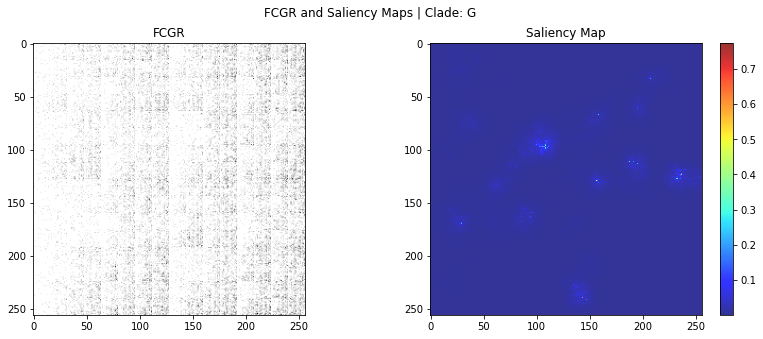

In [43]:
fig = plot(avg_freq, avg_sm)

In [35]:
# k-mer importance  
pos2kmer = fcgrpos2kmers(k=k)
kmer_importance = get_kmer_importance(avg_sm, 
                    threshold=0.2, 
                    array_freq=avg_freq, 
                    pos2kmer=pos2kmer
                    )

pd.DataFrame(kmer_importance)

,kmer,row,col,grad,freq
0,GGATGTTA,123,236,0.774437,0.000428
1,TTTTCGGT,239,143,0.644410,0.001926
2,GCAAACCT,129,156,0.499119,0.978600
3,GGGTGTTA,127,232,0.481134,1.980098
4,CCAACTTC,96,108,0.402442,0.000428
5,CGAACTTC,98,108,0.334837,0.013910
6,TTGTATGA,111,187,0.310729,1.948641
7,TCATAGCG,169,29,0.309061,0.007276
8,GTAAACGA,67,158,0.272808,0.005778
9,GGAACTTC,99,108,0.258902,0.791355


___
# Plots of FCGR representative and Saliency Maps

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

def plot(array_freq, grad_eval, clade):
    "FCGR vs Saliency Maps"
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(array2img(array_freq), cmap="gray")
    i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    fig.suptitle(f"FCGR and Saliency Maps | Clade: {clade}")
    axes[0].set_title("FCGR")
    axes[1].set_title("Saliency Map")
    return fig

In [31]:
clade = "GK"
basepath = "avg-results"
array_freq = np.load(f"{basepath}/{clade}/kmer_frequency.npy")
grad_eval  = np.load(f"{basepath}/{clade}/saliency_map.npy")

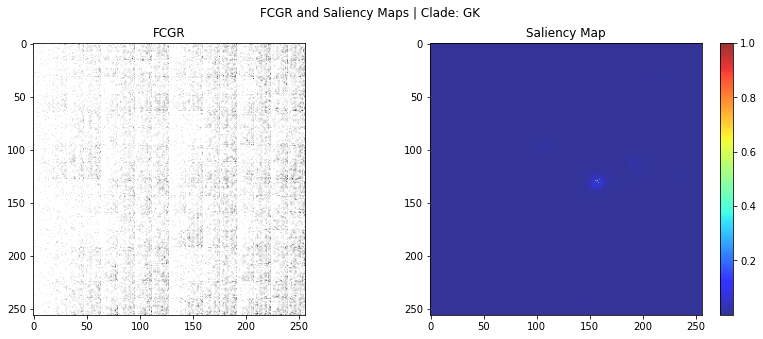

In [32]:
fig = plot(array_freq, grad_eval, clade)

In [33]:
fig.savefig(f"{basepath}/fcgr_saliencymap_clade-{clade}.jpg")